In [1]:
import pandas  as pd
import os
import numpy as np
import datetime 
import glob
pd.set_option('display.max_rows', 110)


import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import torch
from torch_geometric.utils import dense_to_sparse, to_dense_adj
from scipy.spatial import distance
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt



Using backend: pytorch


In [2]:
# download dataset from : https://data.epa.gov.tw/dataset/aqx_p_488

# df = pd.DataFrame()
# for r,ds,fs in os.walk(r'C:\Users\crown\OneDrive\桌面\新增資料夾\2021\aqx_p_488_2021-07'):
#     fs = [f for f in fs if f.endswith('.csv')]
#     for f in fs:
#         p = os.path.join(r,f)
#         print(p)
        
#         df_tmp = pd.read_csv(p)
        
#         df = df.append(df_tmp)
        
#         del df_tmp
        
# df.to_csv(r'./data/df_2021_07.csv',index=False,encoding='ansi')   

In [3]:
class PM25Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='PM25')

    def process(self):
        
        df = self.gen_df()
        self.nodes_data = df
        col_features=[ 'SO2', 'CO', 'O3', 'O3_8hr', 'PM10', 'NO2', 'NOx', 'NO', 'WindSpeed', 'WindDirec', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG']
        node_features = torch.from_numpy(df[col_features].to_numpy())
        node_features = (node_features-node_features.mean(axis=(0,1)))/node_features.std(axis=(0,1))
        node_features = torch.tensor(node_features, dtype=torch.float32)
        node_labels = torch.from_numpy(df[['PM2.5']].to_numpy())
        node_labels = torch.tensor(node_labels, dtype=torch.float32)
        
        edge_index, dist = self.gen_edge()
        
        edge_features = torch.from_numpy(dist)
        edges_src = torch.from_numpy(edge_index[0])
        edges_dst = torch.from_numpy(edge_index[1])

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=self.nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = self.nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def gen_df(self):
        df = pd.read_csv(r'./data/df_2021_07.csv',encoding='ansi')
        df = df[['SO2', 'CO', 'O3', 'O3_8hr', 'PM10', 'NO2', 'NOx', 'NO', 'WindSpeed', 'WindDirec', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG','PM2.5','Longitude','Latitude']]
        
        df = df.replace({'-':0}).astype(float).dropna()
        df[['Longitude','Latitude']] = df[['Longitude','Latitude']].apply(lambda x:round(x,5))

        from sklearn.utils import shuffle
        df = shuffle(df)
        return df
    
    def gen_edge(self):
        
        node_num = self.nodes_data.shape[0]
        coords = []
        for i,r in self.nodes_data.iterrows():
            coords.append([r['Longitude'], r['Latitude']])

        dist = distance.cdist(coords, coords, 'euclidean')
        adj = np.zeros((node_num, node_num), dtype=np.uint8)
        adj[dist <= 0.4] = 1
        assert adj.shape == dist.shape
        dist = dist * adj #
        edge_index, dist = dense_to_sparse(torch.tensor(dist)) # convert to spare tensor
        edge_index, dist = edge_index.numpy(), dist.numpy()
        dist = np.log1p(1/dist)
        return edge_index, dist
    
    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [4]:
dataset = PM25Dataset()
graph = dataset[0]

print(graph)

C:\Users\crown\.conda\envs\yp37_pytorch170_GNN\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Users\crown\.conda\envs\yp37_pytorch170_GNN\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Graph(num_nodes=28607, num_edges=138648656,
      ndata_schemes={'feat': Scheme(shape=(14,), dtype=torch.float32), 'label': Scheme(shape=(1,), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


In [5]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv( in_feats=in_feats, out_feats=out_feats, aggregator_type='lstm')
        # self.conv2 = dglnn.SAGEConv( in_feats=hid_feats, out_feats=hid_feats, aggregator_type='mean')
        # self.conv3 = dglnn.SAGEConv( in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
        self.linear1 = nn.Linear(out_feats,1)
    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv3(graph, h)
        h = self.linear1(h)
        return h

In [6]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]

In [7]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        loss = F.mse_loss(logits, labels)
        return loss

In [8]:
model = SAGE(in_feats=n_features, hid_feats=20, out_feats=10)

opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',factor=0.1, patience=10, threshold=0.0001,)

train_losses,val_losses = [],[]

In [ ]:
early_stop = 10
min_val_loss = 999999
min_val_epoch = 0

for epoch in range(100):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    # compute loss
    train_loss = F.mse_loss(logits[train_mask], node_labels[train_mask])
    # backward propagation
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    train_losses.append(train_loss.item())
    
    val_loss = evaluate(model, graph, node_features, node_labels, valid_mask)
    val_losses.append(val_loss.item())
    
    # scheduler.step(val_loss)
    
    print('#{}, train loss:{:.4f} val loss{:.4f}'.format(epoch,train_loss.item(),val_loss.item()),end='')
    
    if val_loss.item() < min_val_loss:
        min_val_loss = val_loss.item()
        min_val_epoch = epoch
    else:
        print(' no improve...',end='')
        
    if epoch >= min_val_epoch + early_stop :
        print(' early stop...')
        break
        

    print()
    # Save model if necessary.  Omitted in this example.
    
test_loss = evaluate(model, graph, node_features, node_labels, test_mask)
print('test loss : {}',test_loss.item())

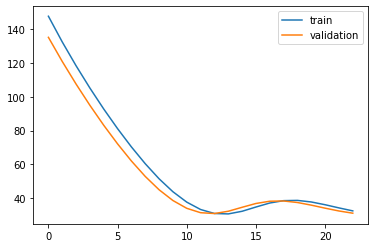

In [27]:
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='validation')
plt.legend()